In [333]:
import numpy as np
import pandas as pd
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import pandas_ta as ta
import talib
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils.OHLC_Helper import getAlphaOHLC
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

API_KEY = 'EC1W3AWVDZ3LA1T8'
ts = TimeSeries(key=API_KEY, output_format='pandas')
ti = TechIndicators(key=API_KEY, output_format='pandas')

(8445, 5)


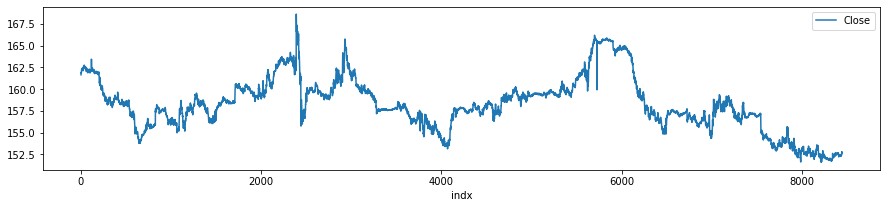

In [334]:
data, meta_data = ts.get_intraday(symbol='AAPL', interval='1min', outputsize='full')
# data, meta_data = ts.get_daily(symbol='GE', outputsize='full')
df = getAlphaOHLC(data)
df['indx'] = np.arange(len(df))
df.index =df['indx']
df.plot(y='Close', figsize=(15, 3))
df.drop(columns=['indx'], inplace=True)
df.tail()
print(f'{df.shape}')

<AxesSubplot:xlabel='indx'>

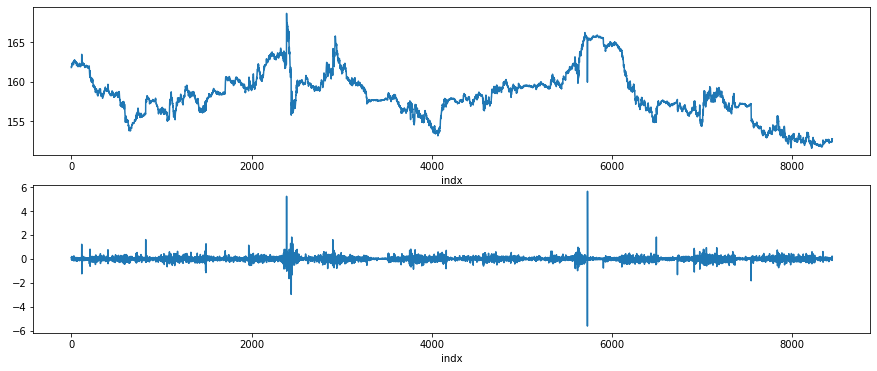

In [335]:
df['ret'] = df['Close'] - df['Close'].shift(1)
ret = df['ret'][1:]
figure, axis = plt.subplots(2,)
ret.plot(figsize=(15, 6))
plt.subplot(2,1,1)
cum = df.Close[0]+np.cumsum(ret)
cum.plot(figsize=(15, 6))

end value 152.74999999999997


,Open,High,Low,Close,Volume,ret,log_ret,log_ret_sum,log_ret_sum_exp
indx,,,,,,,,,
0,162.2228,162.2228,161.6436,161.6436,1369.0,NaN,NaN,NaN,NaN
1,161.7035,161.7734,161.7035,161.7734,2728.0,0.1298,0.000803,0.000803,1.000803
2,161.7535,161.9132,161.7535,161.9132,1654.0,0.1398,0.000864,0.001666,1.001668
3,162.0430,162.0430,161.8433,161.8433,2005.0,-0.0699,-0.000432,0.001235,1.001235
4,161.8833,161.8833,161.8833,161.8833,612.0,0.0400,0.000247,0.001482,1.001483


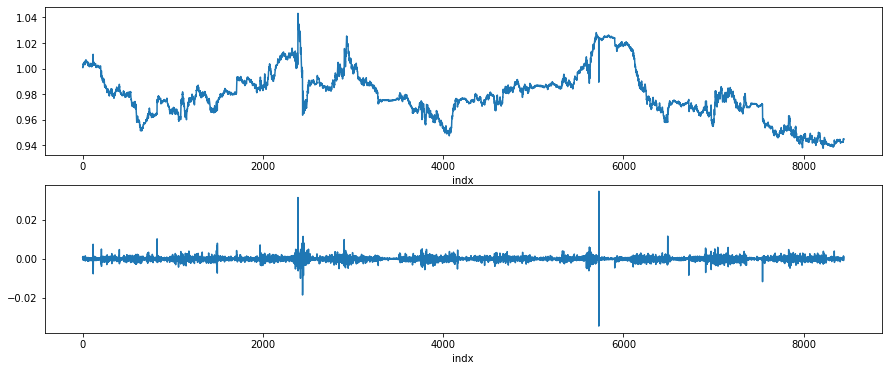

In [336]:
df['log_ret'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
log_ret = df['log_ret'][1:]
df['log_ret_sum'] = np.cumsum(df['log_ret'])
df['log_ret_sum_exp']= np.exp(df['log_ret_sum'])

figure, axis = plt.subplots(2, )
df['log_ret'].plot(figsize=(15, 6))
plt.subplot(2,1,1)
df['log_ret_sum_exp'].plot(figsize=(15, 6))
print(f'end value', df['log_ret_sum_exp'][len(df)-1] * df['Close'][0])
df.head()

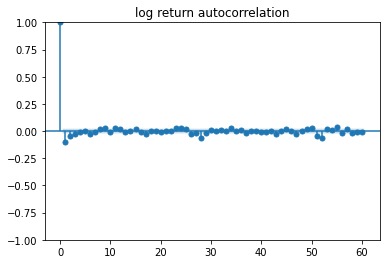

In [337]:
lag = 60
_ = plot_acf(ret, lags=lag, title='log return autocorrelation')

/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


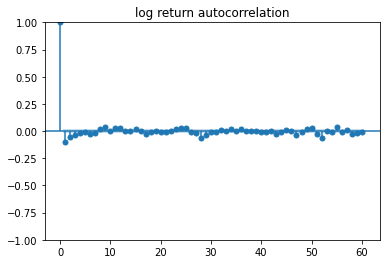

In [338]:
_ = plot_pacf(ret, lags=lag, title='log return autocorrelation')

split start 1688 end 6756
split 0.2 1688
total data length: 8444
train data length: 6756
test data length: 1688


indx
1       0.1298
2       0.1398
3      -0.0699
4       0.0400
5       0.0998
         ...  
6752   -0.0100
6753    0.0100
6754   -0.1800
6755   -0.0600
6756   -0.0400
Name: ret, Length: 6756, dtype: float64

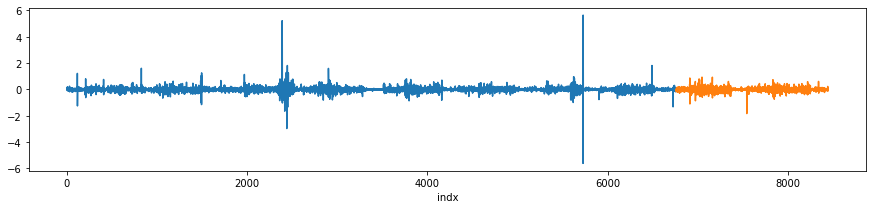

In [339]:
split_percent = 0.2
split = int(len(ret) * split_percent)
split_start = split
split_end = len(ret) - split
print(f'split start {split_start} end {split_end}')
print(f'split {split_percent} {split}')
train_data = ret[:len(ret) -split]
test_data = ret[-1*split:]
print(f'total data length: {len(ret)}')
print(f'train data length: {len(train_data)}')
print(f'test data length: {len(test_data)}')

train_data.plot(figsize=(15, 3))
test_data.plot(figsize=(15, 3))
train_data

In [340]:
AR_lag_p = 20
MA_lag_q = 9
order = (AR_lag_p, 0, MA_lag_q)
arma_model = ARIMA(train_data, order=order)
arma_result = arma_model.fit()

/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary sta

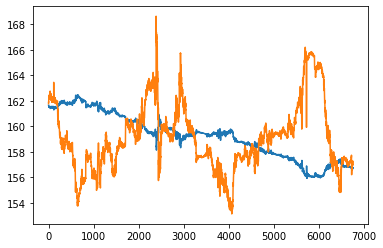

In [341]:
arma_pred = pd.Series(arma_result.fittedvalues)
cum_pred = df.Close[0]+np.cumsum(arma_pred)
cum_ret = df.Close[0]+np.cumsum(train_data.values)
plt.plot(cum_pred, label='predicted')
plt.plot(cum_ret, label='actual')
# plt.plot(lret.values)


/Users/tharshikan/Library/Caches/pypoetry/virtualenvs/quanttrading-_M_FVGhZ-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


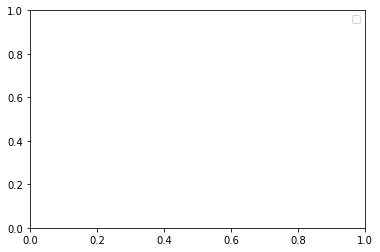

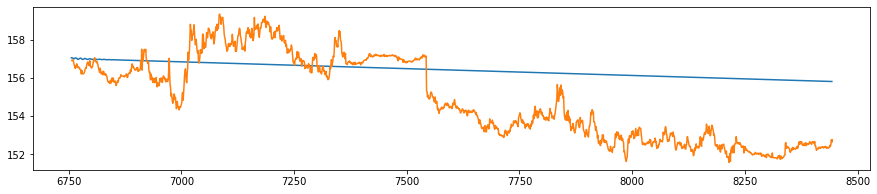

In [342]:

test = arma_result.predict(split_end, len(ret)-1)
cum_test = df.Close[split_end]+np.cumsum(test)
plt.legend()
plt.figure(figsize=(15, 3))
plt.plot(cum_test, label='predicted',)
a= np.cumsum(test_data)+ df.Close[split_end]
plt.plot(a, label='actual')